In [2]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [3]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.autopredictors.scripts.virt_scan_data import load_partial_pointclouds
from tf_lab.point_clouds.conditional_gan import ConditionalGAN
from tf_lab.point_clouds.raw_gan import RawGAN

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
n_pc_samples = 2048
do_training = True
first_time_running = True
load_model = False
seed = 42
max_training_epochs = 100
loss = 'chamfer'

syn_id = shape_net_category_to_synth_id()['chair']
experiment_name = 'raw_pc_chair_gan' + str(n_pc_samples) +  'pts_' + loss

In [6]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )
model_unames = full_model_ids + '.' + full_syn_ids

6778 files containing complete point clouds were found.


In [44]:
full_data = PointCloudDataSet(full_pclouds, labels=model_unames)

In [47]:
reset_tf_graph()
init_lr = 0.001
cgan = RawGAN(learning_rate=init_lr, n_output=[n_pc_samples, 3])

In [48]:
train_stats = []
batch_size = 50
for i in range(100):
    stat_i = cgan._single_epoch_train(full_data, batch_size, sigma=1)
    print stat_i
    train_stats.append(stat_i[0])

((1.5019390636020236, 0.89198415809207487), 24.89339804649353)
((1.3962785650182654, 0.6947227838966582), 24.833162784576416)
((1.4118472346553097, 0.70023540239091275), 24.94038701057434)
((1.3980229624995479, 0.71207155121697319), 24.932651042938232)
((1.3864012206042255, 0.69011624477527755), 24.90443706512451)
((1.4066043615341186, 0.71097330870451747), 24.94282078742981)
((1.3862943649291992, 0.69311648121586555), 24.938366889953613)
((1.3862943649291992, 0.69314717363428191), 24.94004511833191)
((1.3862943649291992, 0.69314718246459961), 24.94429111480713)
((1.3862943649291992, 0.69314718246459961), 24.938616037368774)
((1.3862943649291992, 0.69314718246459961), 24.88817596435547)


KeyboardInterrupt: 

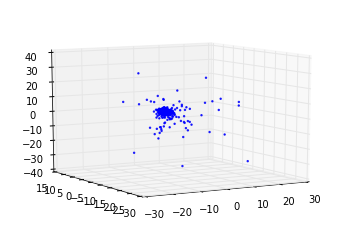

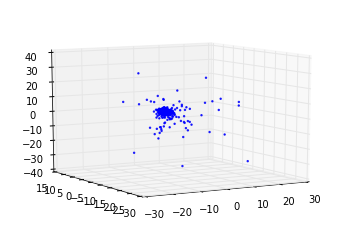

In [50]:
# cgan.
pc_gen = cgan.generate(cgan.generator_noise_distribution(1, 128, sigma=1))[0]
pc_gen = Point_Cloud(points=pc_gen[0])
pc_gen.plot()